In [59]:
# Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import MobileNetV2, mobilenet_v2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Input Pipeline

In [60]:
fish_dir = 'Fish_Dataset' 

path = []
label = []


for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if filename.endswith('.png') and 'GT' not in dir_name:
            
            folder_name = dir_name.split(os.sep)[-1]

            folder_name = folder_name.replace('Hourse Mackerel', 'Horse Mackerel')
            folder_name = folder_name.replace('Gilt-Head Bream', 'Gilt Head Bream')
            
            label.append(folder_name)
            path.append(os.path.join(dir_name, filename))


data = pd.DataFrame({'path': path, 'label': label})
data['label'] = data['label'].replace('Hourse Mackerel', 'Horse Mackerel')
data['label'] = data['label'].replace('Gilt-Head Bream', 'Gilt Head Bream')

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [62]:
data.head()

,path,label
0,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
1,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
2,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
3,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat
4,Fish_Dataset\Black Sea Sprat\Black Sea Sprat\0...,Black Sea Sprat


In [63]:
data['label'].unique() # Subclasses of the categorical variable "label"

array(['Black Sea Sprat', 'Gilt Head Bream', 'Horse Mackerel',
       'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp',
       'Striped Red Mullet', 'Trout'], dtype=object)

In [64]:
data['label'].value_counts(ascending=True)

label
Black Sea Sprat       1000
Gilt Head Bream       1000
Horse Mackerel        1000
Red Mullet            1000
Red Sea Bream         1000
Sea Bass              1000
Shrimp                1000
Striped Red Mullet    1000
Trout                 1000
Name: count, dtype: int64

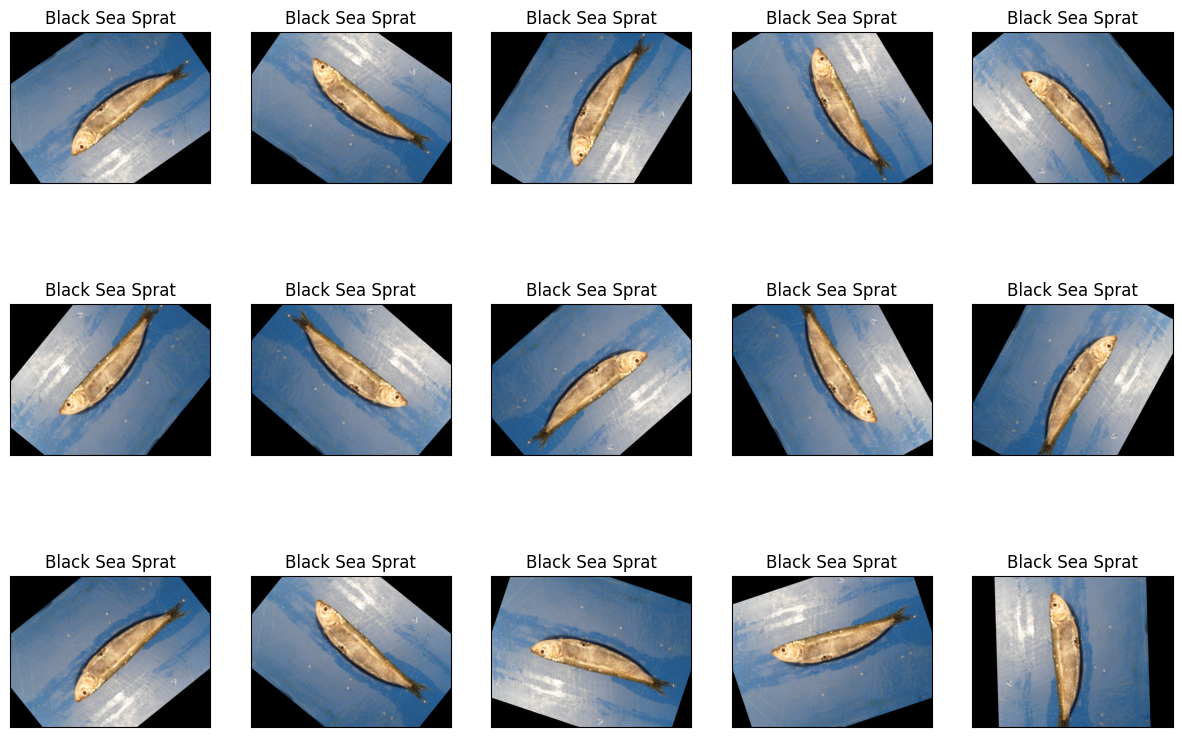

In [65]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.path[i]))
    ax.set_title(data.label[i])
    
plt.show()

Divide the dataset into training, validating and testing data

In [66]:
#Train Test Split 
x_train, x_test = train_test_split(data, test_size=0.3, shuffle=True, random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [67]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5040, 2)
Shape of test data (2700, 2)
Shape of validation data (1260, 2)


In [68]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [69]:
def preprocess_image(file_path, label):
    # Read and decode the image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0  # Rescale the image pixels to [0, 1]
    return img, label

def create_dataset(dataframe, batch_size=BATCH_SIZE, is_training=True):
    paths = dataframe['path'].values
    labels = dataframe['label'].values
    
    # Label encoding
    unique_labels = sorted(set(labels))
    label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
    labels = [label_encoder[label] for label in labels]
    
    # Dynamically compute the number of classes
    num_classes = len(unique_labels)
    
    # One-hot encode labels for training

    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
    
    # Create TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Add augmentation for training
    if is_training:
        def augment_image(image, label):
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
            return image, label
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Shuffle, batch, and prefetch
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train = create_dataset(x_train, is_training=True)
val = create_dataset(x_val, is_training=False)
test = create_dataset(x_test, is_training=False)

# Image classification using Multi Layer Perceptron (MLP)

Create the model

In [70]:
mlp_model = tf.keras.models.Sequential()

# Input layer
mlp_model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

# Flatten layer
mlp_model.add(tf.keras.layers.Flatten())

# 3 Hidden Layers with (256, 256, 128) neurons and relu activation function
mlp_model.add(tf.keras.layers.Dense(256, activation='relu'))
# Dropout layer to reduce overfitting
mlp_model.add(tf.keras.layers.Dropout(0.4))
mlp_model.add(tf.keras.layers.Dense(256, activation='relu'))
mlp_model.add(tf.keras.layers.Dense(128, activation='relu'))

# Output layer with 9 neurons and softmax activation function
mlp_model.add(tf.keras.layers.Dense(9, activation='softmax'))


In [71]:
mlp_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,635,273 (147.38 MB)

 Trainable params: 38,635,273 (147.38 MB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [72]:
mlp_model.compile(loss='categorical_crossentropy',
                 optimizer='rmsprop',
                 metrics=['acc'])

mlp_model.fit(train,validation_data=val,epochs=5)

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 51s 294ms/step - acc: 0.1137 - loss: 18.7361 - val_acc: 0.1016 - val_loss: 2.1974
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 62s 296ms/step - acc: 0.1230 - loss: 2.2590 - val_acc: 0.1008 - val_loss: 2.1978
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - acc: 0.1128 - loss: 2.3294 - val_acc: 0.1008 - val_loss: 2.1979
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 50s 273ms/step - acc: 0.1118 - loss: 2.1975 - val_acc: 0.1008 - val_loss: 2.1979
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 63s 305ms/step - acc: 0.1087 - loss: 2.2723 - val_acc: 0.1008 - val_loss: 2.1980


Testing result

In [73]:
results = mlp_model.evaluate(test)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - acc: 0.1043 - loss: 2.1978
Test Loss: 2.19784
Test Accuracy: 10.85%


In [74]:
pred = mlp_model.predict(test)
pred=np.argmax(pred,axis=1)

85/85 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step


In [75]:
# Step 2: Get true labels from the test dataset
y_true = []
for _, labels in test:  # Iterate over the test dataset
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices
y_true = np.array(y_true)

In [76]:
cm = confusion_matrix(y_true, pred)

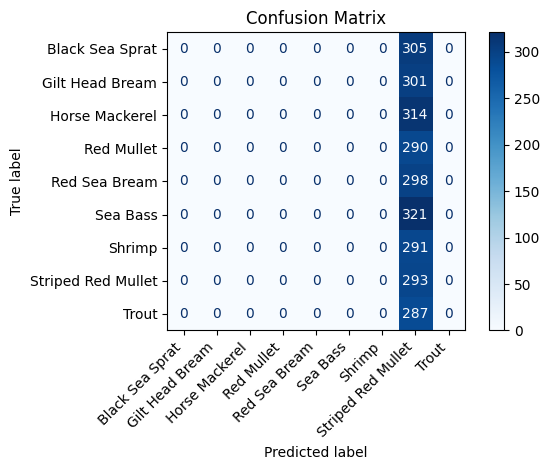

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = sorted(set(x_test['label'].values))  # Replace with actual class names if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align to the right
plt.title("Confusion Matrix")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [78]:
from sklearn.metrics import classification_report

pred_df = pd.DataFrame({
    'label': y_true,
    'pred': pred
})

print("Classification Report:")
print(classification_report(pred_df['label'], pred_df['pred'], target_names=class_names, zero_division=0))

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.00      0.00      0.00       305
   Gilt Head Bream       0.00      0.00      0.00       301
    Horse Mackerel       0.00      0.00      0.00       314
        Red Mullet       0.00      0.00      0.00       290
     Red Sea Bream       0.00      0.00      0.00       298
          Sea Bass       0.00      0.00      0.00       321
            Shrimp       0.00      0.00      0.00       291
Striped Red Mullet       0.11      1.00      0.20       293
             Trout       0.00      0.00      0.00       287

          accuracy                           0.11      2700
         macro avg       0.01      0.11      0.02      2700
      weighted avg       0.01      0.11      0.02      2700



We will loss the spatial features of the image when we flattening the image to 2D vector, we will loss a lot of information and the network does not relate the pixel values to each other when it is trying to find patterns thats why we get a very bad accuracy when we use MLP in such problem.

Why??

1. Loss of information

* When we Flatten the image to be a 1D vector, the pixel values that present the fish will be distributed in a certain way in the vector lets say in the left side of the image, if we have a new image that has the same object but in different location in the image, the neural network will not recognize it because different neurons need to fires in order to recognize the fish, the neural network will have no idea that this is the same fish. But why it does better than that on the MNIST data set, because MNIST data are well prepared for this task. The MLP will not learn the fish shape.

2. Very large number of parameters

* Another problem with the MLP is that it is an Fully connected layer, where every node in the layer is connected to all nodes of the previous layer and all nodes in the next layer. You saw that with this simple network we have more that 24 million parameters to learn, with more complex network and larger image size we will end up with billions of parameters to train and it is very computationally expensive.

Next we will use Convolutional neural networks to train the classifier

# Image classification using Convolutional Neural Networks (CNN)

Building the model

In [79]:
# Building the model 
cnn_model = tf.keras.models.Sequential()

#----------------------------------------------------------------------------------------------

# Conv layer: 32 filters of size (3, 3), with strides = 1 and relu activation
cnn_model.add(tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
cnn_model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

# Conv layer: 64 filters of size (3, 3), with strides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

# Conv layer: 128 filters of size (3, 3), with strides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

# Conv layer: 128 filters of size (3, 3), with strides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------

# Conv layer: 256 filters of size (3, 3), with strides = 1 and relu activation
cnn_model.add(tf.keras.layers.Conv2D(256, kernel_size=(3, 3), strides=1, 
                                    activation='relu'))
cnn_model.add(tf.keras.layers.BatchNormalization())
cnn_model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#----------------------------------------------------------------------------------------------
# Global Average Pooling
cnn_model.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully connected layer with 256 units and relu activation
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout layer to lower the overfitting with dropout rate of 0.4
cnn_model.add(tf.keras.layers.Dropout(0.4))

# Fully connected layer with 9 units and softmax activation
cnn_model.add(tf.keras.layers.Dense(9, activation='softmax'))

In [80]:
cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 606,537 (2.31 MB)

 Trainable params: 605,321 (2.31 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [81]:
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer='rmsprop',
                 metrics=['acc'])

In [82]:
history = cnn_model.fit(train, validation_data=val, epochs=5)

Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - acc: 0.5963 - loss: 1.1661 - val_acc: 0.1095 - val_loss: 10.4363
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - acc: 0.8850 - loss: 0.3332 - val_acc: 0.1175 - val_loss: 11.0272
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - acc: 0.9416 - loss: 0.1779 - val_acc: 0.1952 - val_loss: 7.8726
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 865ms/step - acc: 0.9597 - loss: 0.1271 - val_acc: 0.4143 - val_loss: 3.9457
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 144s 882ms/step - acc: 0.9666 - loss: 0.0976 - val_acc: 0.7603 - val_loss: 1.1036


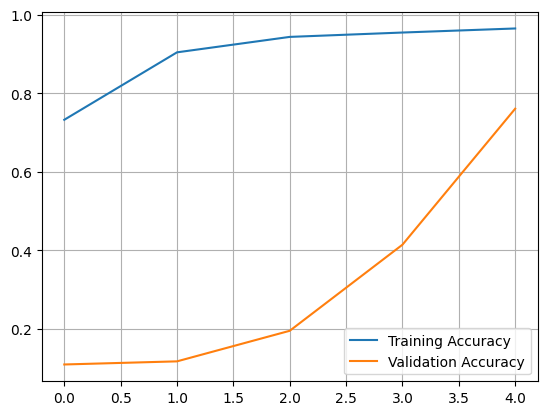

In [83]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(history.epoch, train_acc, label='Training Accuracy')
plt.plot(history.epoch, val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [84]:
results = cnn_model.evaluate(test)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 198ms/step - acc: 0.7724 - loss: 1.0789
Test Loss: 1.13432
Test Accuracy: 76.00%


In [85]:
pred = cnn_model.predict(test)
pred = np.argmax(pred, axis=1)

85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step


In [86]:
# Step 2: Get true labels from the test dataset
y_true = []
for _, labels in test:  # Iterate over the test dataset
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to class indices
y_true = np.array(y_true)

In [87]:
cm = confusion_matrix(y_true, pred)

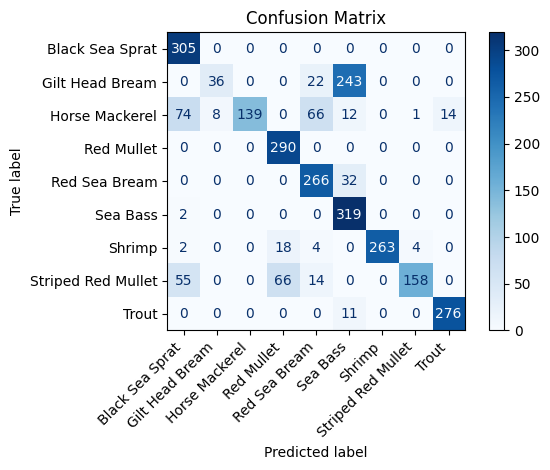

In [88]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = sorted(set(x_test['label'].values))  # Replace with actual class names if available
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees and align to the right
plt.title("Confusion Matrix")
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [89]:
from sklearn.metrics import classification_report

pred_df = pd.DataFrame({
    'label': y_true,
    'pred': pred
})

print("Classification Report:")
print(classification_report(pred_df['label'], pred_df['pred'], target_names=class_names))

Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.70      1.00      0.82       305
   Gilt Head Bream       0.82      0.12      0.21       301
    Horse Mackerel       1.00      0.44      0.61       314
        Red Mullet       0.78      1.00      0.87       290
     Red Sea Bream       0.72      0.89      0.79       298
          Sea Bass       0.52      0.99      0.68       321
            Shrimp       1.00      0.90      0.95       291
Striped Red Mullet       0.97      0.54      0.69       293
             Trout       0.95      0.96      0.96       287

          accuracy                           0.76      2700
         macro avg       0.83      0.76      0.73      2700
      weighted avg       0.82      0.76      0.73      2700

